# **Load Libraries**

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
import OptimalK
from transformers import AutoTokenizer, AutoModel
import umap
import plotly.express as px
import re

'''
TODO: Visualize which MDS are most likely to be mixed up

'''

'\nTODO: Visualize which MDS are most likely to be mixed up\n\n'

# **Data Loading**

In [154]:
path = 'data/data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1') # Using a different encoding while info is fixed

First we set a path for the data that we want to use.
* We utilize pandas to read the csv file and use a specified encoding.
* This encoding ISO-8859-1 is also known as Latin-1 which is a character encoding standard for Western European Languages.

In [155]:
import chardet

# Open the file in binary mode
with open('data/data.csv', 'rb') as f:
    # Detect encoding
    result = chardet.detect(f.read())
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


Here we run chardet, which is a library that helps detect a file's encoding. 
* It outputs the recommended encoder along with the conifdence
* The output is Windows-1251, which is an extension of ISO-8859-1.

Let's see which is more accurate....

In [156]:
# Define a function to strip trailing whitespace
def strip_whitespace(cell):
    if isinstance(cell, str):  # Check if the value is a string ( if x is str)
        return cell.strip()    # Strip whitespace from strings (leading and trailing)
    return cell                # Return non-strings unchanged

# Load with ISO-8859-1 agian for readability in example
df_iso = pd.read_csv('data/data.csv', encoding='ISO-8859-1')
df_iso = df_iso.map(strip_whitespace)

# Load with Windows-1252
df_win = pd.read_csv('data/data.csv', encoding='Windows-1252')
df_win = df_win.map(strip_whitespace)

# Align the DataFrames to ensure they have the same structure (columns and indices)- or else we cannot do a comparision
df_iso_aligned = df_iso.reindex_like(df_win)
df_win_aligned = df_win.reindex_like(df_iso)

# Check if both DataFrames are equal
comparison = df_iso_aligned.equals(df_win_aligned)
print("Are the DataFrames identical?", comparison)

# If not, display differences
different_columns = []  # Start with an empty list

for col in df_iso_aligned.columns:  # Iterate over all columns
    if not df_iso_aligned[col].equals(df_win_aligned[col]):  # Check for differences
        different_columns.append(col)  # Add the column name to the list

print(different_columns)

# Showcase different rows
if not comparison:
    for col in df_iso_aligned.columns:
        # Compare individual columns
        differences = df_iso_aligned[col].compare(df_win_aligned[col])
        if not differences.empty: #empty if there was no difference
            print(f"Differences found in rows {col}:")
            print(differences.head(10))

Are the DataFrames identical? False
['Paper', 'Dataset', 'Goal', 'Abstract']
Differences found in rows Paper:
                                                 self  \
8   THE PREDICTION OF DYSTONIA PATIENTS BEHAVIOR ...   
13  Identification of Freezing of Gait in Parkinso...   
15  Video-based diagnosis support system for piani...   
19  Hold that pose: capturing cervical dystonias ...   
21  Implementation of a Deep Learning Algorithm Ba...   
39  Bradykinesia Detection in Parkinson's Disease ...   
40  Automatic assessment of Parkinson's patients ...   
54  Multimodal Classification of Parkinsons Disea...   
60  Grouping successive freezing of gait episodes\...   
62  Prediction of Freezing of Gait in\nParkinsons...   

                                                other  
8   THE PREDICTION OF DYSTONIA PATIENTS’ BEHAVIOR ...  
13  Identification of Freezing of Gait in Parkinso...  
15  Video-based diagnosis support system for piani...  
19  Hold that pose: capturing cervical

Wow that's a lot of differences! Our output shows differences in the rows ['Paper', 'Dataset', 'Goal', 'Abstract'].
Without limiting to the 10 differences to each corresponding row (differences.head(10)), we would have a new datafram showcasing the idfferences of 107 rows x 2 columns.
* 107 differences and 2 colums, one for each dataframe

This could make a difference in our embeddings and clustering, so we should therefore use the Windows-1252 encoding for better accuracy. It's also the recommended encoder for excel in general.

# **Embeddings Functions**

In [157]:
def GetCategoriesSum(df, category_name: str):
    category = dict()

    for entry in df[category_name]:
        if pd.isnull(entry):
            continue  

        items = entry.split(',')
        for item in items:
            item = item.strip() 
            if item:  
                if item in category:
                    category[item] += 1
                else:
                    category[item] = 1
                    
    return category


def EmbedFrame(df, category_name: str, model: SentenceTransformer):
    embeddings = model.encode(df[category_name].tolist())
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) 
    return embeddings


def CreateCluster(df, embeddings, num_clusters, title):

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignments = clustering_model.labels_

    for sentence_id, cluster_id in enumerate(cluster_assignments):
        df.loc[sentence_id, title] = cluster_id


def PrintCluster(cluster):
    for cluster_id, mds_list in cluster.items():
        print(f"\nCluster {cluster_id}:")
        print("-" * 20)
        for mds in mds_list:
            print(f"- {mds}")

def ReduceEmbedding(embedded_text, neighbors=100, min_distance=0.0):
    reducer = umap.UMAP(n_neighbors=neighbors, n_components=2, random_state=42, min_dist=min_distance)
    return reducer.fit_transform(embedded_text)
    
def VisualizeCluster(df, graph_title, reduced_embeddings, cluster_title: str, category: str = "MDS Simplified", show_authors=False, show_country=False, show_sample_size=False, show_patient_count=False, show_control_count=False, show_year=False, show_data_source=False, show_algorithm=False, show_task=False, show_cv=False, show_performance_metric=False, show_dataset=False, show_goal=False, show_wearable=False):
    df[category] = df[category].str.strip().str.upper()
    #Authors	Year	Paper	Country	MDS	Data Source Primary	Data Source Secondary	Algorithm	Task	Cross Validation	Performance Metric	Sample Size	Dataset	Goal	Abstract	Person	Notes	Wearable Location
    plot_df = pd.DataFrame({
        'UMAP1': reduced_embeddings[:, 0],
        'UMAP2': reduced_embeddings[:, 1],
        'MDS Simplified': df[category],
        'Paper': df['Paper'], 
        'MDS': df['MDS'],
        cluster_title: df[cluster_title].astype(str),
        "Authors": df["Authors"],
        "Country": df["Country"],
        "Sample Size": df["Sample Size"],
        "Patient Count": df["Patient Count"],
        "Control Count": df["Control Count"],
        "Year": df["Year"],
        "Data Source Secondary": df["Data Source Secondary"],
        "Algorithm" : df["Algorithm"],
        "Task": df["Task"],
        "CV" : df["Cross Validation"],
        "Performance Metric": df["Performance Metric"],
        "Dataset": df["Dataset"],
        "Goal": df["Goal"],
        "Wearable": df["Wearable Location"]


    })
    
    symbol_map = {
        '0.0': 'circle',
        '1.0': 'square',
        '2.0': 'diamond',
        '3.0': 'triangle-up',
        '4.0': 'star',
        '5.0': 'bowtie',
        '6.0': 'pentagon',
        '7.0': 'triangle-left',
        '8.0': 'diamond-cross',
        '9.0': 'triangle-down',
        '10.0': 'triangle-right',
    }

    fig = px.scatter(
        plot_df, 
        hover_data={'MDS': True, 'Paper': True, "Authors" : show_authors, "Country": show_country, "Sample Size": show_sample_size, "Patient Count": show_patient_count, "Control Count": show_control_count, "Year": show_year, "Data Source Secondary": show_data_source, "Algorithm": show_algorithm, "Task": show_task, "CV": show_cv, "Performance Metric": show_performance_metric, "Dataset": show_dataset, "Goal": show_goal, "Wearable": show_wearable}, 
        x='UMAP1', 
        y='UMAP2', 
        color='MDS Simplified', 
        symbol=cluster_title,   
        symbol_map=symbol_map,   
        title=graph_title,
        labels={"UMAP1": "UMAP Component 1", "UMAP2": "UMAP Component 2"}
    )
    
    fig.update_layout(
        legend_title_text='MDS Simplified and Cluster ID',
        title_font_size=16,
        xaxis_title="UMAP Component 1",
        yaxis_title="UMAP Component 2",
        template="plotly_white"
    )
    
    fig.show()


def GetClusterAccuracy(df, cluster_title):
    total_count = len(df[cluster_title])
    mode_count = df[cluster_title].value_counts().max()
    cluster_accuracy = mode_count / total_count
    return cluster_accuracy

def FormatSampleSize(df):
    patient_list = []
    control_list = []

    for ss in df["Sample Size"]:
        if pd.isnull(ss) or "NA" in str(ss).upper():
            patient_list.append(0)
            control_list.append(0)
            continue
        
        ss = str(ss)
        patient_count = 0
        control_count = 0

        matches = re.findall(r'(\d+)\s*([A-Za-z]*)', ss)
        for num_str, word in matches:
            num = int(num_str)
            if 'CONTROL' in word.upper():
                control_count += num
            else:
                patient_count += num

        patient_list.append(patient_count)
        control_list.append(control_count)
    
    df["Patient Count"] = patient_list
    df["Control Count"] = control_list


def SimplifyMDS(df):
    simplified_list = []
    for mds in df["MDS"]:
        if pd.isnull(mds):
            simplified_list.append(None)
            continue
        mds_upper = mds.strip().upper()
        if "ATAXIA" in mds_upper:
            simplified_list.append("ATAXIA")
        elif "DYSTONIA" in mds_upper:
            simplified_list.append("DYSTONIA")
        elif "BRADYKINESIA" in mds_upper:
            simplified_list.append("BRADYKINESIA")
        elif "TREMOR" in mds_upper:
            simplified_list.append("TREMOR")
        elif "ET" in mds_upper:
            simplified_list.append("ET")
        elif "FOG" in mds_upper:
            simplified_list.append("FOG")
        elif "DYSKINESIA" in mds_upper:
            simplified_list.append("DYSKINESIA")
        else:
            simplified_list.append(mds_upper)

    df["MDS Simplified"] = simplified_list


# **ML VARIABLES**

# Original with whitespace

In [158]:
df = df.dropna(subset=["Authors"]).reset_index(drop=True)
SimplifyMDS(df)
FormatSampleSize(df)

# Windows encoder

In [159]:
df_win = df_win.dropna(subset=["Authors"]).reset_index(drop=True)
SimplifyMDS(df_win)
FormatSampleSize(df_win)

# Original without whitespace

In [160]:
df_iso = df_iso.dropna(subset=["Authors"]).reset_index(drop=True)
SimplifyMDS(df_iso)
FormatSampleSize(df_iso)

In [161]:
#model = SentenceTransformer("all-MiniLM-L6-v2") # Change model to bio
#model2 = SentenceTransformer("../models/sentence-transformers/emilyalsentzer_Bio_ClinicalBERTo_ClinicalBERT")
#model2 = SentenceTransformer("monologg/biobert_v1.1_pubmed")

#tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
#model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")
'''
- UMAP > t-SNE (better at preserving global structure & performance)
    - Higher n_neighbor --> more global structure
        - Higher noise, focus on large-scale trends
    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.
        - Good for high-dimensional datasets where clusters are more continuous or overlapping.
        - Suitable when your clusters are discrete and well-separated in high-dimensional space.
        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.

'''

'\n- UMAP > t-SNE (better at preserving global structure & performance)\n    - Higher n_neighbor --> more global structure\n        - Higher noise, focus on large-scale trends\n    - Lower min_dist --> tightly packed, highly distinguishable clusters, emphasizing local density.\n        - Good for high-dimensional datasets where clusters are more continuous or overlapping.\n        - Suitable when your clusters are discrete and well-separated in high-dimensional space.\n        - Helpful for applications like classification tasks, where precise boundaries between clusters are desired.\n\n'

# **GENERAL VISUALIZATION**

# Original with whitespace

In [162]:
type(df['Country'].value_counts())

pandas.core.series.Series

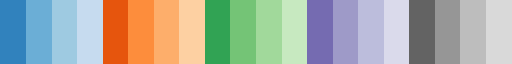

In [163]:
cm.tab20c

**Papers by country**

# Original with whitespace

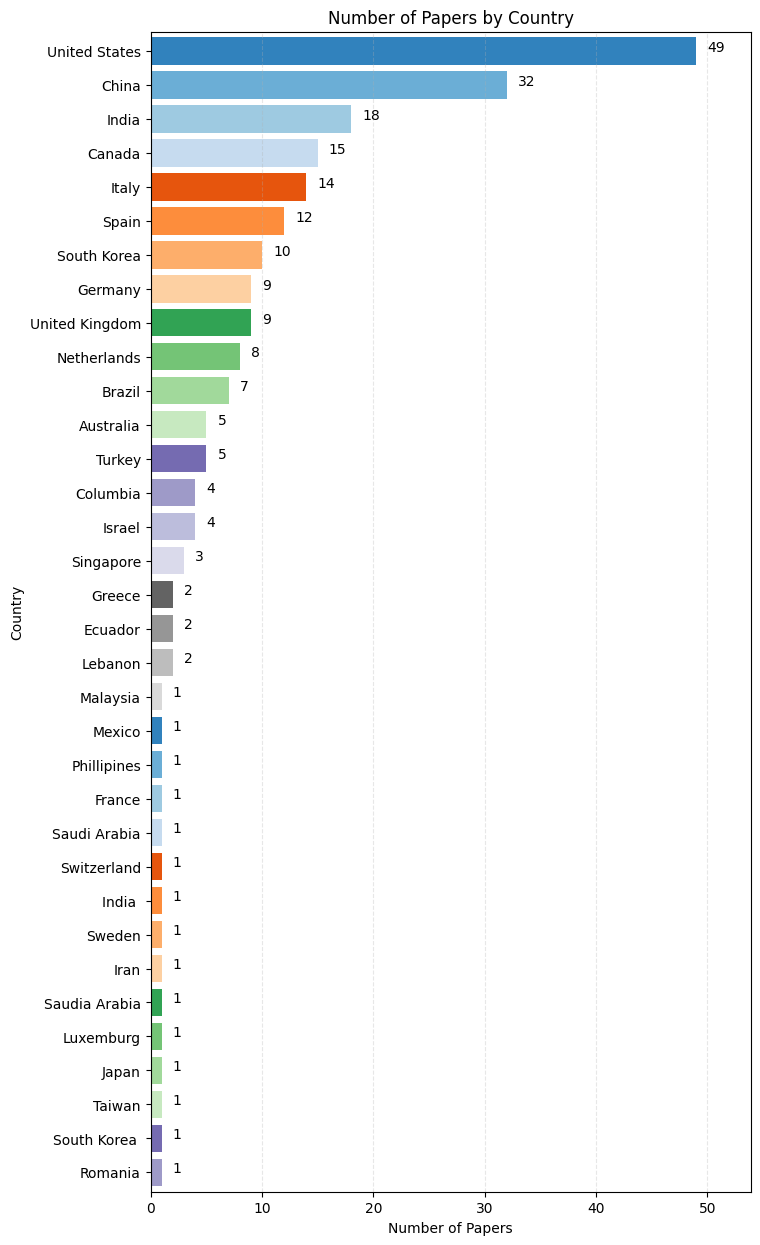

In [164]:
# Plot the horizontal bar graph with spacing between bars
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(country_counts.index, country_counts.values, color=cm.tab20c.colors[:len(country_counts)])
# Set the x-axis label
max_count = country_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Country')
plt.title('Number of Papers by Country')

for i, v in enumerate(country_counts.values):
        plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=1.5, bottom=0.05)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

**Papers by Person**

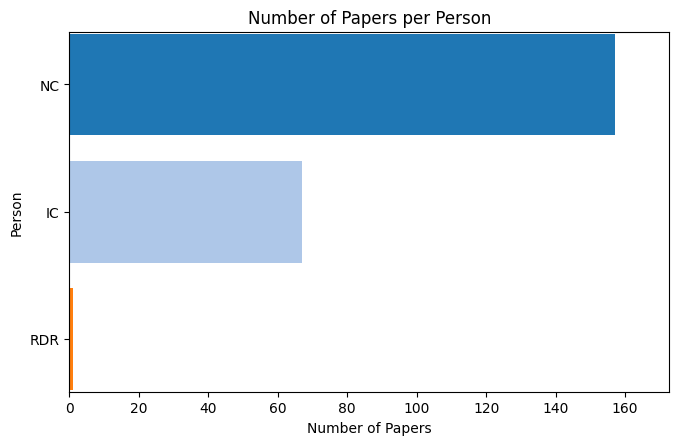

In [165]:
# Plot the horizontal bar graph with spacing between bars
person_counts = df['Person'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(person_counts.index, person_counts.values, color=cm.tab20.colors[:len(person_counts)])
# Set the x-axis label
max_count = person_counts.max()
plt.xlim(0, max_count + max_count * 0.1)
plt.margins(y=0.005)
# Labels and title with padding
plt.xlabel('Number of Papers')
plt.ylabel('Person')
plt.title('Number of Papers per Person')

# for i, v in enumerate(person_counts.values):
#         plt.text(v + 1, i, str(v))

# Increase spacing between plot elements if needed
plt.subplots_adjust(left=0.3, right=0.9, top=0.5, bottom=0.05)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# Optional: invert y-axis for descending order
plt.gca().invert_yaxis()
plt.show()

**Data Source Counts**

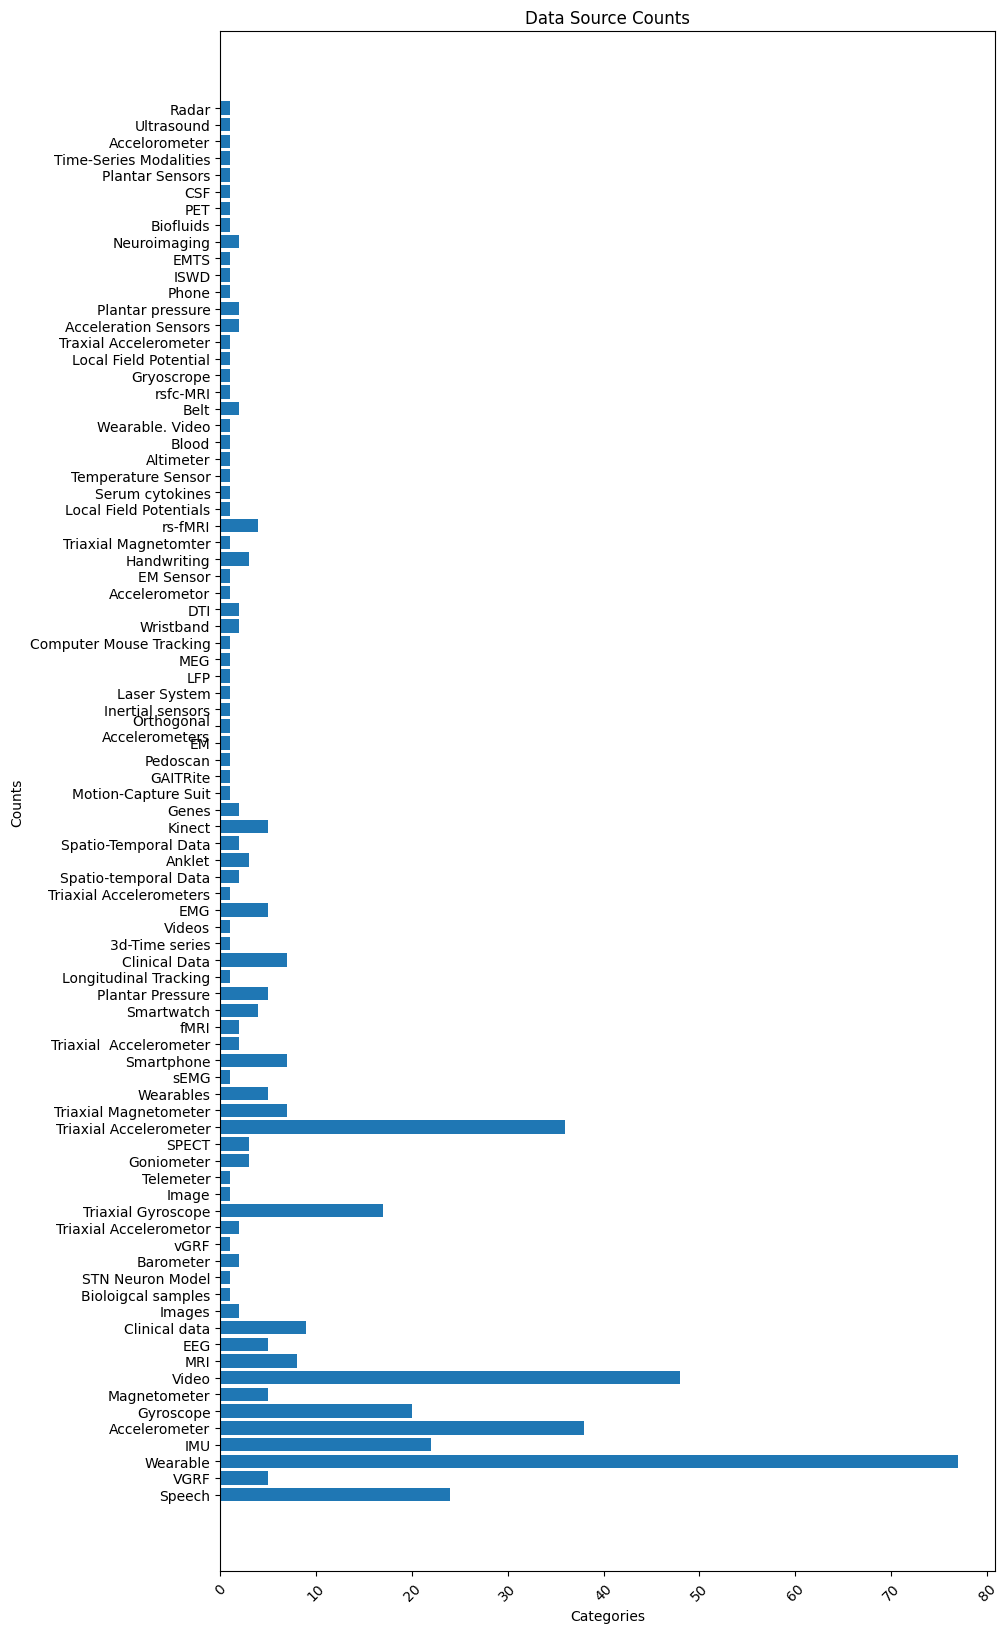

In [166]:
category_counts = GetCategoriesSum(df, "Data Source Secondary")

# Convert dictionary to Series for plotting
category_counts_series = pd.Series(category_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 20))
plt.barh(category_counts_series.index, category_counts_series.values)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Data Source Counts')
plt.xticks(rotation=45)
plt.show()

# DF encoder difference


We know that we have differences with our decoder- so we should see if that actually made a difference. 
* Abstract was one of the affected columns-let's visualize the clustering

# **PAPER**

## Original ISO encoder

In [167]:
df["Paper"] = df["Paper"].fillna("")
embedded_papers_original = EmbedFrame(df, "Paper", model)
embedded_reduced_papers_original = ReduceEmbedding(embedded_papers_original, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_papers_original, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df, "Title", embedded_reduced_papers_original, "Reduced Paper Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [168]:
df_iso["Paper"] = df_iso["Paper"].fillna("")
embedded_papers = EmbedFrame(df_iso, "Paper", model)
embedded_reduced_papers = ReduceEmbedding(embedded_papers, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_papers, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df_iso, "Title", embedded_reduced_papers, "Reduced Paper Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [169]:
df_win["Paper"] = df_win["Paper"].fillna("")
embedded_papers_win = EmbedFrame(df_win, "Paper", model)
embedded_reduced_papers_win = ReduceEmbedding(embedded_papers_win, neighbors=100, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_papers_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_papers_win, num_clusters, "Reduced Paper Cluster")
VisualizeCluster(df_win, "Title", embedded_reduced_papers_win, "Reduced Paper Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **AUTHORS**

## Original ISO encoder

In [170]:
df["Authors"] = df["Authors"].fillna("")
embedded_authors_original = EmbedFrame(df, "Authors", model)
embedded_reduced_authors_original = ReduceEmbedding(embedded_authors_original, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_authors_original, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df, "Authors", embedded_reduced_authors_original, "Reduced Authors Cluster", show_authors=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [171]:
df_iso["Authors"] = df_iso["Authors"].fillna("")
embedded_authors = EmbedFrame(df_iso, "Authors", model)
embedded_reduced_authors = ReduceEmbedding(embedded_authors, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_authors, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df_iso, "Authors", embedded_reduced_authors, "Reduced Authors Cluster", show_authors=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [172]:
df_win["Authors"] = df_win["Authors"].fillna("")
embedded_authors_win = EmbedFrame(df_win, "Authors", model)
embedded_reduced_authors_win = ReduceEmbedding(embedded_authors_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_authors_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_authors_win, num_clusters, "Reduced Authors Cluster")
VisualizeCluster(df_win, "Authors", embedded_reduced_authors_win, "Reduced Authors Cluster", show_authors=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **ABSTRACT**

## Original ISO encoder

In [173]:
df["Abstract"] = df["Abstract"].fillna("")
embedded_abstracts_original = EmbedFrame(df, "Abstract", model)
embedded_reduced_abstracts_original = ReduceEmbedding(embedded_abstracts_original, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_abstracts_original, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df, "Abstract", embedded_reduced_abstracts_original, "Reduced Abstract Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [174]:
df_iso["Abstract"] = df_iso["Abstract"].fillna("")
embedded_abstracts = EmbedFrame(df_iso, "Abstract", model)
embedded_reduced_abstracts = ReduceEmbedding(embedded_abstracts, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_abstracts, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df_iso, "Abstract", embedded_reduced_abstracts, "Reduced Abstract Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [175]:
df_win["Abstract"] = df_win["Abstract"].fillna("")
embedded_abstracts_win = EmbedFrame(df_win, "Abstract", model)
embedded_reduced_abstracts_win = ReduceEmbedding(embedded_abstracts_win, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_abstracts_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_abstracts_win, num_clusters, "Reduced Abstract Cluster")
VisualizeCluster(df_win, "Abstract", embedded_reduced_abstracts_win, "Reduced Abstract Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **COUNTRY**

## Original ISO encoder

In [176]:
df["Country"] = df["Country"].fillna("")
embedded_countries_original = EmbedFrame(df, "Country", model)
embedded_reduced_countries_original = ReduceEmbedding(embedded_countries_original, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_countries_original, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df, "Country", embedded_reduced_countries_original, "Reduced Country Cluster", show_country=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [177]:
df_iso["Country"] = df_iso["Country"].fillna("")
embedded_countries = EmbedFrame(df_iso, "Country", model)
embedded_reduced_countries = ReduceEmbedding(embedded_countries, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_countries, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df_iso, "Country", embedded_reduced_countries, "Reduced Country Cluster", show_country=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [178]:
df_win["Country"] = df_win["Country"].fillna("")
embedded_countries_win = EmbedFrame(df_win, "Country", model)
embedded_reduced_countries_win = ReduceEmbedding(embedded_countries_win, neighbors=12, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_countries_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_countries_win, num_clusters, "Reduced Country Cluster")
VisualizeCluster(df_win, "Country", embedded_reduced_countries_win, "Reduced Country Cluster", show_country=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **DATA SOURCE SECONDARY**

## Original ISO encoder

In [179]:
df["Data Source Secondary"] = df["Data Source Secondary"].fillna("")
embedded_dss_original = EmbedFrame(df, "Data Source Secondary", model)
embedded_reduced_dss_original = ReduceEmbedding(embedded_dss_original, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_dss_original, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df, "Data Source Secondary", embedded_reduced_dss_original, "Reduced Data Source Secondary Cluster", show_data_source=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [180]:
df_iso["Data Source Secondary"] = df_iso["Data Source Secondary"].fillna("")
embedded_dss = EmbedFrame(df_iso, "Data Source Secondary", model)
embedded_reduced_dss = ReduceEmbedding(embedded_dss, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_dss, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df_iso, "Data Source Secondary", embedded_reduced_dss, "Reduced Data Source Secondary Cluster", show_data_source=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [181]:
df_win["Data Source Secondary"] = df_win["Data Source Secondary"].fillna("")
embedded_dss_win = EmbedFrame(df_win, "Data Source Secondary", model)
embedded_reduced_dss_win = ReduceEmbedding(embedded_dss_win, neighbors=10, min_distance=.45)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_dss_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_dss_win, num_clusters, "Reduced Data Source Secondary Cluster")
VisualizeCluster(df_win, "Data Source Secondary", embedded_reduced_dss_win, "Reduced Data Source Secondary Cluster", show_data_source=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **ALGORITHM**

## Original ISO encoder

In [182]:
df["Algorithm"] = df["Algorithm"].fillna("")
embedded_algorithms_original = EmbedFrame(df, "Algorithm", model)
embedded_reduced_algorithms_original = ReduceEmbedding(embedded_algorithms_original, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_algorithms_original, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df, "Algorithm", embedded_reduced_algorithms_original, "Reduced Algorithm Cluster", show_algorithm=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [183]:
df_iso["Algorithm"] = df_iso["Algorithm"].fillna("")
embedded_algorithms = EmbedFrame(df_iso, "Algorithm", model)
embedded_reduced_algorithms = ReduceEmbedding(embedded_algorithms, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_algorithms, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df_iso, "Algorithm", embedded_reduced_algorithms, "Reduced Algorithm Cluster", show_algorithm=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [184]:
df_win["Algorithm"] = df_win["Algorithm"].fillna("")
embedded_algorithms_win = EmbedFrame(df_win, "Algorithm", model)
embedded_reduced_algorithms_win = ReduceEmbedding(embedded_algorithms_win, neighbors=10, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_algorithms_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_algorithms_win, num_clusters, "Reduced Algorithm Cluster")
VisualizeCluster(df_win, "Algorithm", embedded_reduced_algorithms_win, "Reduced Algorithm Cluster", show_algorithm=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **TASK**

## Original ISO encoder

In [185]:
df["Task"] = df["Task"].fillna("")
embedded_tasks_original = EmbedFrame(df, "Task", model)
embedded_reduced_tasks_original = ReduceEmbedding(embedded_tasks_original, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_tasks_original, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df, "Task", embedded_reduced_tasks_original, "Reduced Task Cluster", show_task=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [186]:
df_iso["Task"] = df_iso["Task"].fillna("")
embedded_tasks = EmbedFrame(df_iso, "Task", model)
embedded_reduced_tasks = ReduceEmbedding(embedded_tasks, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_tasks, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df_iso, "Task", embedded_reduced_tasks, "Reduced Task Cluster", show_task=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [187]:
df_win["Task"] = df_win["Task"].fillna("")
embedded_tasks_win = EmbedFrame(df_win, "Task", model)
embedded_reduced_tasks_win = ReduceEmbedding(embedded_tasks_win, neighbors=5, min_distance=.35)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_tasks_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_tasks_win, num_clusters, "Reduced Task Cluster")
VisualizeCluster(df_win, "Task", embedded_reduced_tasks_win, "Reduced Task Cluster", show_task=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **CROSS VALIDATION**

## Original ISO encoder

In [188]:
df["Cross Validation"] = df["Cross Validation"].fillna("")
embedded_cvs_original = EmbedFrame(df, "Cross Validation", model)
embedded_reduced_cvs_original = ReduceEmbedding(embedded_cvs_original, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_cvs_original, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df, "Cross Validation", embedded_reduced_cvs_original, "Reduced Cross Validation Cluster", show_cv=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



# Without whitespace

In [189]:
df_iso["Cross Validation"] = df_iso["Cross Validation"].fillna("")
embedded_cvs = EmbedFrame(df_iso, "Cross Validation", model)
embedded_reduced_cvs = ReduceEmbedding(embedded_cvs, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_cvs, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df_iso, "Cross Validation", embedded_reduced_cvs, "Reduced Cross Validation Cluster", show_cv=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



## Windows encoder

In [190]:
df_win["Cross Validation"] = df_win["Cross Validation"].fillna("")
embedded_cvs_win = EmbedFrame(df_win, "Cross Validation", model)
embedded_reduced_cvs_win = ReduceEmbedding(embedded_cvs_win, neighbors=500, min_distance=.25)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_cvs_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_cvs_win, num_clusters, "Reduced Cross Validation Cluster")
VisualizeCluster(df_win, "Cross Validation", embedded_reduced_cvs_win, "Reduced Cross Validation Cluster", show_cv=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



# **PERFORMANCE METRIC**

## Original ISO encoder

In [191]:
df["Performance Metric"] = df["Performance Metric"].fillna("")
embedded_pms_original = EmbedFrame(df, "Performance Metric", model)
embedded_reduced_pms_original = ReduceEmbedding(embedded_pms_original, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_pms_original, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df, "Performance Metric", embedded_reduced_pms_original, "Reduced Performance Metric Cluster", show_performance_metric=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [192]:
df_iso["Performance Metric"] = df_iso["Performance Metric"].fillna("")
embedded_pms = EmbedFrame(df_iso, "Performance Metric", model)
embedded_reduced_pms = ReduceEmbedding(embedded_pms, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_pms, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df_iso, "Performance Metric", embedded_reduced_pms, "Reduced Performance Metric Cluster", show_performance_metric=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [193]:
df_win["Performance Metric"] = df_win["Performance Metric"].fillna("")
embedded_pms_win = EmbedFrame(df_win, "Performance Metric", model)
embedded_reduced_pms_win = ReduceEmbedding(embedded_pms_win, neighbors=50, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_pms_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_pms_win, num_clusters, "Reduced Performance Metric Cluster")
VisualizeCluster(df_win, "Performance Metric", embedded_reduced_pms_win, "Reduced Performance Metric Cluster", show_performance_metric=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [194]:
''' TODO: Use Scatter Plot w/ Integers
df["Sample Size"] = df["Sample Size"].fillna("")

embedded_patient_count = EmbedFrame(df, "Patient Count", model)
embedded_control_count = EmbedFrame(df, "Control Count", model)

embedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)
embedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)

embedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")
VisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")
'''

' TODO: Use Scatter Plot w/ Integers\ndf["Sample Size"] = df["Sample Size"].fillna("")\n\nembedded_patient_count = EmbedFrame(df, "Patient Count", model)\nembedded_control_count = EmbedFrame(df, "Control Count", model)\n\nembedded_reduced_patient_count = ReduceEmbedding(embedded_patient_count, neighbors=50, min_distance=0)\nembedded_reduced_control_count = ReduceEmbedding(embedded_control_count, neighbors=50, min_distance=0)\n\nembedded_sample_size = np.concatenate((embedded_reduced_patient_count, embedded_reduced_control_count), axis=1)\n\noptimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend=\'joblib\')\nnum_clusters = optimalKObj(embedded_sample_size, n_refs=50, cluster_array=np.arange(1,10))\nCreateCluster(df, embedded_sample_size, num_clusters, "Reduced Patient Count Cluster")\nVisualizeCluster(df, "Patient Count", embedded_sample_size, "Reduced Patient Count Cluster")\n'

# **DATASET**

## Original ISO encoder

In [195]:
#TODO: Write out full dataset acronym
df["Dataset"] = df["Dataset"].fillna("")
embedded_datasets_original = EmbedFrame(df, "Dataset", model)
embedded_reduced_datasets_original = ReduceEmbedding(embedded_datasets_original, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_datasets_original, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df, "Dataset", embedded_reduced_datasets_original, "Reduced Dataset Cluster", show_dataset=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [196]:
#TODO: Write out full dataset acronym
df_iso["Dataset"] = df_iso["Dataset"].fillna("")
embedded_datasets = EmbedFrame(df_iso, "Dataset", model)
embedded_reduced_datasets = ReduceEmbedding(embedded_datasets, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_datasets, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df_iso, "Dataset", embedded_reduced_datasets, "Reduced Dataset Cluster", show_dataset=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [197]:
#TODO: Write out full dataset acronym
df_win["Dataset"] = df_win["Dataset"].fillna("")
embedded_datasets_win = EmbedFrame(df_win, "Dataset", model)
embedded_reduced_datasets_win = ReduceEmbedding(embedded_datasets_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_datasets_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_datasets_win, num_clusters, "Reduced Dataset Cluster")
VisualizeCluster(df_win, "Dataset", embedded_reduced_datasets_win, "Reduced Dataset Cluster", show_dataset=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **GOAL**

## Original ISO encoder

In [198]:
df["Goal"] = df["Goal"].fillna("")
embedded_goals_original = EmbedFrame(df, "Goal", model)
embedded_reduced_goals_original = ReduceEmbedding(embedded_goals_original, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_goals_original, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df, "Goal", embedded_reduced_goals_original, "Reduced Goal Cluster", show_goal=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [199]:
df_iso["Goal"] = df_iso["Goal"].fillna("")
embedded_goals = EmbedFrame(df_iso, "Goal", model)
embedded_reduced_goals = ReduceEmbedding(embedded_goals, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_goals, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df_iso, "Goal", embedded_reduced_goals, "Reduced Goal Cluster", show_goal=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [200]:
df_win["Goal"] = df_win["Goal"].fillna("")
embedded_goals_win = EmbedFrame(df_win, "Goal", model)
embedded_reduced_goals_win = ReduceEmbedding(embedded_goals_win, neighbors=2, min_distance=.5)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_goals_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_goals_win, num_clusters, "Reduced Goal Cluster")
VisualizeCluster(df_win, "Goal", embedded_reduced_goals_win, "Reduced Goal Cluster", show_goal=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **WEARABLE LOCATION**

## Original ISO encoder

In [201]:
df["Wearable Location"] = df["Wearable Location"].fillna("")
embedded_wearable_locs_original = EmbedFrame(df, "Wearable Location", model)
embedded_reduced_wearable_locs_original = ReduceEmbedding(embedded_wearable_locs_original, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_wearable_locs_original, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df, "Wearable Location", embedded_reduced_wearable_locs_original, "Reduced Wearable Location Cluster", show_wearable=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

In [202]:
df_iso["Wearable Location"] = df_iso["Wearable Location"].fillna("")
embedded_wearable_locs = EmbedFrame(df_iso, "Wearable Location", model)
embedded_reduced_wearable_locs = ReduceEmbedding(embedded_wearable_locs, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_iso, embedded_reduced_wearable_locs, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df_iso, "Wearable Location", embedded_reduced_wearable_locs, "Reduced Wearable Location Cluster", show_wearable=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Windows encoder

In [203]:
df_win["Wearable Location"] = df_win["Wearable Location"].fillna("")
embedded_wearable_locs_win = EmbedFrame(df_win, "Wearable Location", model)
embedded_reduced_wearable_locs_win = ReduceEmbedding(embedded_wearable_locs_win, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_wearable_locs_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_wearable_locs_win, num_clusters, "Reduced Wearable Location Cluster")
VisualizeCluster(df_win, "Wearable Location", embedded_reduced_wearable_locs_win, "Reduced Wearable Location Cluster", show_wearable=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# **HIGH DIMENSIONALITY**

## Original ISO encoder

In [204]:
 # High Dimensionality, beneficial if each feature captures unique and important data, diluted distance

embedding_list_original = [     
    embedded_authors_original,
    embedded_reduced_wearable_locs_original,
    embedded_reduced_tasks_original,
    embedded_reduced_datasets_original,
    embedded_reduced_papers_original,
    embedded_reduced_dss_original,
    embedded_reduced_goals_original,
    embedded_reduced_abstracts_original,
    embedded_reduced_countries_original,
    embedded_reduced_algorithms_original,
    embedded_reduced_cvs_original,
    embedded_reduced_pms_original
]

high_dimensionality_embeddings = np.concatenate(embedding_list_original, axis=1)

embedded_reduced_high_dim= ReduceEmbedding(high_dimensionality_embeddings, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_high_dim, num_clusters, "Reduced High Dimensionality Total Cluster")
VisualizeCluster(df, "Reduced High Dimensionality", embedded_reduced_high_dim, "Reduced High Dimensionality Total Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



# Without whitespace

## Windows encoder

In [205]:
 # High Dimensionality, beneficial if each feature captures unique and important data, diluted distance

embedding_list_win = [     
    embedded_reduced_wearable_locs_win,
    embedded_authors_win,
    embedded_reduced_tasks_win,
    embedded_reduced_datasets_win,
    embedded_reduced_papers_win,
    embedded_reduced_dss_win,
    embedded_reduced_goals_win,
    embedded_reduced_abstracts_win,
    embedded_reduced_countries_win,
    embedded_reduced_algorithms_win,
    embedded_reduced_cvs_win,
    embedded_reduced_pms_win
]

high_dimensionality_embeddings_win = np.concatenate(embedding_list_win, axis=1)

embedded_reduced_high_dim_win= ReduceEmbedding(high_dimensionality_embeddings_win, neighbors=2, min_distance=0)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_high_dim_win, num_clusters, "Reduced High Dimensionality Total Cluster")
VisualizeCluster(df_win, "Reduced High Dimensionality", embedded_reduced_high_dim_win, "Reduced High Dimensionality Total Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



# **LOW DIMENSIONALITY**

## Original ISO encoder

In [206]:
# Can use "memory" of previous clusters by column + all base data
# Captures patterns throughout features, but may dilute the importance of individual features - distances are more meaningful - 
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_original = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_original = ReduceEmbedding(embedded_low_dimensionality_original, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality_original, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality_original, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality_original, "Reduced Low Dimensionality Total Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

## Windows encoder

In [207]:
# Can use "memory" of previous clusters by column + all base data
# Captures patterns throughout features, but may dilute the importance of individual features - distances are more meaningful - 
df_win["Low Dimensionality Total"] = df_win.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_win["Low Dimensionality Total"] = df_win["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality_win = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality_win = ReduceEmbedding(embedded_low_dimensionality_win, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality_win, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df_win, embedded_reduced_low_dimensionality_win, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df_win, "Low Dimensionality Total", embedded_reduced_low_dimensionality_win, "Reduced Low Dimensionality Total Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Print

In [208]:
print(df.columns)
df = df.drop('Reduced Paper Cluster', axis=1)
df = df.drop('Reduced Authors Cluster', axis=1)
df = df.drop('Reduced Abstract Cluster', axis=1)
df = df.drop('Reduced Country Cluster', axis=1)
df = df.drop('Reduced Data Source Secondary Cluster', axis=1)
df = df.drop('Reduced Algorithm Cluster', axis=1)
df = df.drop('Reduced Task Cluster', axis=1)
df = df.drop('Reduced Cross Validation Cluster', axis=1)
df = df.drop('Reduced Performance Metric Cluster', axis=1)
df = df.drop('Reduced Dataset Cluster', axis=1)
df = df.drop('Reduced Goal Cluster', axis=1)
df = df.drop('Reduced Wearable Location Cluster', axis=1)
df = df.drop('Reduced High Dimenstionality Total Cluster', axis=1)


Index(['Authors', 'Year', 'Paper', 'Country', 'MDS', 'Data Source Primary',
       'Data Source Secondary', 'Algorithm', 'Task', 'Cross Validation',
       'Performance Metric', 'Sample Size', 'Dataset', 'Goal', 'Abstract',
       'Person', 'Notes', 'Wearable Location', 'MDS Simplified',
       'Patient Count', 'Control Count', 'Reduced Paper Cluster',
       'Reduced Authors Cluster', 'Reduced Abstract Cluster',
       'Reduced Country Cluster', 'Reduced Data Source Secondary Cluster',
       'Reduced Algorithm Cluster', 'Reduced Task Cluster',
       'Reduced Cross Validation Cluster',
       'Reduced Performance Metric Cluster', 'Reduced Dataset Cluster',
       'Reduced Goal Cluster', 'Reduced Wearable Location Cluster',
       'Reduced High Dimensionality Total Cluster', 'Low Dimensionality Total',
       'Reduced Low Dimensionality Total Cluster'],
      dtype='object')


KeyError: "['Reduced High Dimenstionality Total Cluster'] not found in axis"

## Original ISO encoder

In [ ]:
# Does not have "memory" of previous clusters + all base data
df["Low Dimensionality Total"] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df["Low Dimensionality Total"] = df["Low Dimensionality Total"].replace('nan', '')


embedded_low_dimensionality = EmbedFrame(df, "Low Dimensionality Total", model)
embedded_reduced_low_dimensionality = ReduceEmbedding(embedded_low_dimensionality, neighbors=3, min_distance=1)
optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_low_dimensionality, n_refs=50, cluster_array=np.arange(1,10))
CreateCluster(df, embedded_reduced_low_dimensionality, num_clusters, "Reduced Low Dimensionality Total Cluster")
VisualizeCluster(df, "Low Dimensionality Total", embedded_reduced_low_dimensionality, "Reduced Low Dimensionality Total Cluster")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

## Windows encoder

## Original ISO encoder

In [ ]:
#TODO: Review Above Graphs for most consequential/separate clusters and adjust weights accordingly
weights = [
    0.0,  # Weight for embedded_authors
    0.0,  # Weight for embedded_reduced_wearable_locs
    0.0,  # Weight for embedded_reduced_tasks
    0.0,  # Weight for embedded_reduced_datasets
    0.0,  # Weight for embedded_reduced_papers
    0.0,  # Weight for embedded_reduced_dss
    0.0,  # Weight for embedded_reduced_goals
    1.0,  # Weight for embedded_reduced_abstracts
    0.0,  # Weight for embedded_reduced_countries
    0.0,  # Weight for embedded_reduced_algorithms
    0.0,  # Weight for embedded_reduced_cvs
    0.0,  # Weight for embedded_reduced_pms
]

embedding_reduced_list_original = [
    embedded_authors_original,
    embedded_reduced_wearable_locs_original,
    embedded_reduced_tasks_original,
    embedded_reduced_datasets_original,
    embedded_reduced_papers_original,
    embedded_reduced_dss_original,
    embedded_reduced_goals_original,
    embedded_reduced_abstracts_original,
    embedded_reduced_countries_original,
    embedded_reduced_algorithms_original,
    embedded_reduced_cvs_original,
    embedded_reduced_pms_original
]

weighted_embeddings = [embedding * weight for embedding, weight in zip(embedding_reduced_list_original, weights)]

weighted_embeddings = [embedding for embedding in weighted_embeddings if not np.all(embedding == 0)]

if len(weighted_embeddings) > 1:
    high_dimensionality_embeddings = np.concatenate(weighted_embeddings, axis=1)
elif len(weighted_embeddings) == 1:
    high_dimensionality_embeddings = weighted_embeddings[0]
else:
    raise ValueError("All weights are zero. Please assign a non-zero weight to at least one embedding.")

embedded_reduced_high_dim = ReduceEmbedding(high_dimensionality_embeddings, neighbors=50, min_distance=0)

optimalKObj = OptimalK.OptimalK(n_jobs=4, parallel_backend='joblib')
num_clusters = optimalKObj(embedded_reduced_high_dim, n_refs=50, cluster_array=np.arange(1, 10))

CreateCluster(df, embedded_reduced_high_dim, num_clusters, "Adjusted Weighted Cluster")
VisualizeCluster(df, "Adjusted Weighted Embeddings", embedded_reduced_high_dim, "Adjusted Weighted Cluster")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Without whitespace

## Windows encoder